In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
from google.colab import drive
from tqdm import trange
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel, TimeSeriesTransformerForPrediction

In [2]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
close = np.load("/content/drive/MyDrive/close_mean_ts_by_network.npy")
open = np.load("/content/drive/MyDrive/open_mean_ts_by_network.npy")

In [4]:
close.shape, open.shape # [networks, subjects, time]

((14, 84, 120), (14, 84, 120))

In [5]:
data = np.concatenate((close, open), axis=1)
data = torch.tensor(data).float()
data = data.reshape((168, 14, 120))

labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

dataset = TensorDataset(data, labels)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=44)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=44)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [6]:
train_ratio = 0
for i in range(len(train_dataset)):
    if train_dataset[i][1].item() == 0:
        train_ratio += 1
print(train_ratio / len(train_dataset))

test_ratio = 0
for i in range(len(test_dataset)):
    if test_dataset[i][1].item() == 0:
        test_ratio += 1
print(test_ratio / len(test_dataset))

0.5308641975308642
0.5490196078431373


In [7]:
len(train_dataset), len(test_dataset), len(val_dataset)

(81, 51, 36)

In [8]:
class TimeSeriesCNN(nn.Module):
    def __init__(self, input_channels, hidden_size, dropout=0.1):
        super(TimeSeriesCNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.input_channels = input_channels

        for _ in range(input_channels):
            self.conv_layers.append(nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=5),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
                nn.Conv1d(128, 64, kernel_size=5),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
                nn.Conv1d(64, 32, kernel_size=5),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
                nn.Conv1d(32, 16, kernel_size=5),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
            ))

        self.fc1 = nn.Linear(1120, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        conv_outs = []
        for i in range(self.input_channels):
            conv_out = self.conv_layers[i](x[:, i:i+1, :])
            conv_outs.append(conv_out)
        conv_out = torch.cat(conv_outs, dim=1)
        conv_out = conv_out.view(conv_out.size(0), -1)
        fc_out = F.relu(self.fc1(conv_out))
        output = torch.sigmoid(self.fc2(fc_out))
        return output.squeeze(1)

In [9]:
input_channels = close.shape[0]
model = TimeSeriesCNN(input_channels, 128)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)

In [10]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
train_roc_auc = []
test_roc_auc = []
val_losses = []

def train(model):
    num_epochs = 30
    print_every = 5
    patience = 4
    epochs_increasing = 0
    last_loss = 100000
    for epoch in range(num_epochs):
        running_loss = 0.0
        y_train_true = []
        y_train_pred_proba = []

        for inputs, labels in train_loader:
            model.train()
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            y_train_true.extend(labels.cpu().tolist())
            y_train_pred_proba.extend(output.cpu().tolist())
            running_loss += loss.item()

        running_loss /= len(train_loader)
        y_train_true = torch.Tensor(y_train_true)
        y_train_pred_proba = torch.Tensor(y_train_pred_proba)
        train_losses.append(running_loss)
        train_pred = (torch.Tensor(y_train_pred_proba) > 0.5).float()
        accuracy = (train_pred == y_train_true).sum().item() / y_train_true.shape[0]
        train_accuracy.append(accuracy)
        roc_auc = roc_auc_score(y_train_true, y_train_pred_proba)
        train_roc_auc.append(roc_auc)

        test_loss = 0.0
        y_test_true = []
        y_test_pred_proba = []
        for inputs, labels in test_loader:
            model.eval()
            output = model(inputs)
            loss = criterion(output, labels)
            test_loss += loss.item()
            y_test_true.extend(labels.cpu().tolist())
            y_test_pred_proba.extend(output.cpu().tolist())

        test_loss /= len(test_loader)
        y_test_true = torch.Tensor(y_test_true)
        y_test_pred_proba = torch.Tensor(y_test_pred_proba)
        test_losses.append(test_loss)
        test_pred = (torch.Tensor(y_test_pred_proba) > 0.5).float()
        accuracy = (test_pred == y_test_true).sum().item() / y_test_true.shape[0]
        test_accuracy.append(accuracy)
        roc_auc = roc_auc_score(y_test_true, y_test_pred_proba)
        test_roc_auc.append(roc_auc)

        val_loss = 0.0
        for inputs, labels in val_loader:
            model.eval()
            output = model(inputs)
            loss = criterion(output, labels)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        if val_loss > last_loss:
            epochs_increasing += 1
            if epochs_increasing >= patience:
                print('Early stopping!\n')
                return
        else:
            epochs_increasing = 0

        last_loss = val_loss
        if epoch % print_every == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {running_loss:.4f}, Test loss: {test_loss:.4f}")

Иногда early stopping может сработать очень рано, но всё должно работать, если просто переинициализировать модель и перезапустить обучение

In [11]:
train(model)

Epoch 1/30, Train loss: 42.4876, Test loss: 37.9380
Epoch 6/30, Train loss: 41.6698, Test loss: 37.0898
Epoch 11/30, Train loss: 40.4265, Test loss: 37.6267
Epoch 16/30, Train loss: 41.1454, Test loss: 35.9267
Epoch 21/30, Train loss: 39.3236, Test loss: 36.4085
Epoch 26/30, Train loss: 40.5926, Test loss: 35.2320


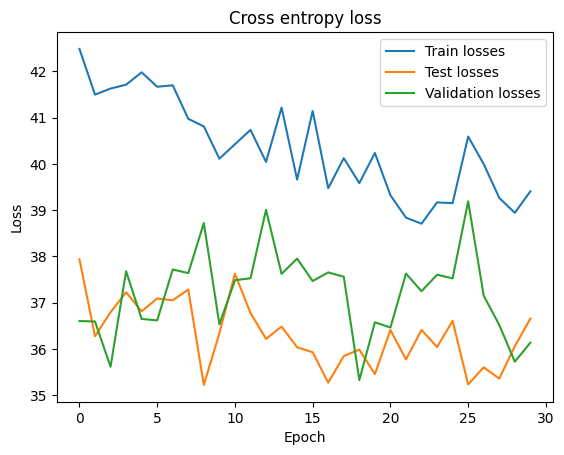

In [12]:
plt.plot(train_losses, label='Train losses')
plt.plot(test_losses, label='Test losses')
plt.plot(val_losses, label='Validation losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss')
plt.legend()
plt.show()

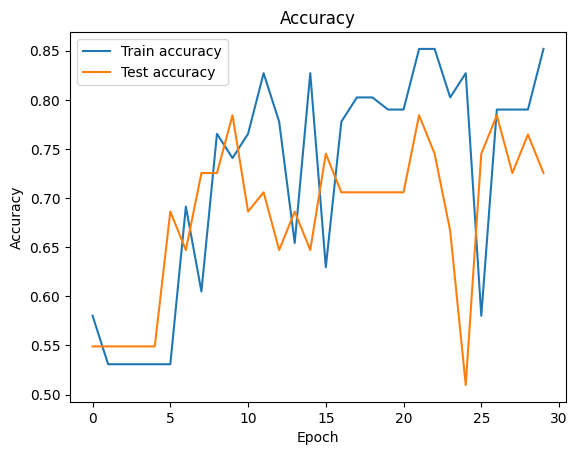

In [13]:
plt.plot(train_accuracy, label='Train accuracy')
plt.plot(test_accuracy, label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

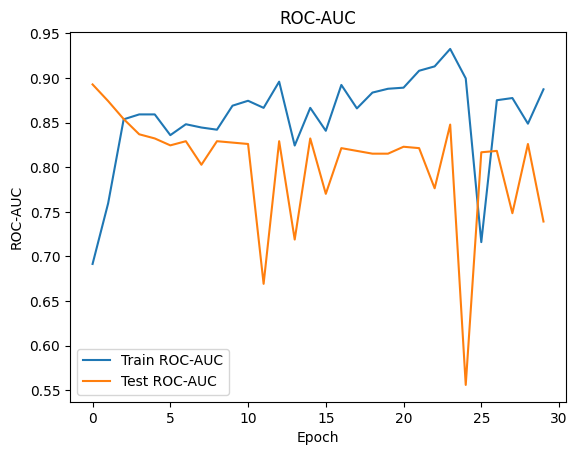

In [14]:
plt.plot(train_roc_auc, label='Train ROC-AUC')
plt.plot(test_roc_auc, label='Test ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.legend()
plt.show()

In [15]:
data = data.reshape((168, 120, 14))

In [16]:
past_values = []
future_values = []
past_time_features = []
future_time_features = []
static_categorical_features = []
for i in range(data.shape[0]):
  start = 0
  while start + 24 < data[i].shape[0]:
    past_values.append(data[i][start : start+20])
    future_values.append(data[i][start+20 : start+24])
    past_time_features.append(range(start, start+20))
    future_time_features.append(range(start+20, start+24))
    static_categorical_features.append(1 - (i // (data.shape[0] // 2)))
    start += 4
past_values = torch.stack(past_values)
future_values = torch.stack(future_values)
past_time_features = torch.Tensor(past_time_features)
future_time_features = torch.Tensor(future_time_features)
past_time_features = past_time_features.reshape((past_time_features.shape[0], past_time_features.shape[1], 1))
future_time_features = future_time_features.reshape((future_time_features.shape[0], future_time_features.shape[1], 1))
past_observed_mask = torch.ones(past_values.shape)
static_categorical_features = torch.Tensor(static_categorical_features).int()

In [17]:
n = past_values.shape[0]
test_size = 0.2
test_idx = np.random.choice(range(n), size=int(test_size * n), replace=False)
train_idx = np.setdiff1d(range(n), test_idx)
train_past_values = past_values[train_idx]
test_past_values = past_values[test_idx]
train_future_values = future_values[train_idx]
test_future_values = future_values[test_idx]
train_past_time_features = past_time_features[train_idx]
test_past_time_features = past_time_features[test_idx]
train_future_time_features = future_time_features[train_idx]
test_future_time_features = future_time_features[test_idx]
train_past_observed_mask = past_observed_mask[train_idx]
test_past_observed_mask = past_observed_mask[test_idx]
train_static_categorical_features = static_categorical_features[train_idx]
test_static_categorical_features = static_categorical_features[test_idx]

In [18]:
batch_size = 512
train_dataset = []
for i in range(train_past_values.shape[0]):
    train_dataset.append({
        "past_values": train_past_values[i],
        "future_values": train_future_values[i],
        "past_time_features": train_past_time_features[i],
        "future_time_features": train_future_time_features[i],
        "past_observed_mask": train_past_observed_mask[i],
        "static_categorical_features": train_static_categorical_features[i]
    })

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = []
for i in range(test_past_values.shape[0]):
    test_dataset.append({
        "past_values": test_past_values[i],
        "future_values": test_future_values[i],
        "past_time_features": test_past_time_features[i],
        "future_time_features": test_future_time_features[i],
        "past_observed_mask": test_past_observed_mask[i],
        "static_categorical_features": test_static_categorical_features[i]
    })

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [19]:
lags_sequence = [1, 2, 3, 4, 5, 6, 7]
configuration = TimeSeriesTransformerConfig(prediction_length=4, context_length=20 - len(lags_sequence), input_size=14,
                                            num_time_features=1, lags_sequence=lags_sequence, num_parallel_samples=1,
                                            num_static_categorical_features=1, cardinality=[2], embedding_dimension=[1])
model = TimeSeriesTransformerForPrediction(configuration)
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

In [20]:
n_epochs = 100
print_every = 10
train_losses = []
test_losses = []
for epoch in range(n_epochs):
    for idx, batch in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()

        loss = model(
            past_values=batch["past_values"],
            future_values=batch["future_values"],
            past_time_features=batch["past_time_features"],
            future_time_features=batch["future_time_features"],
            past_observed_mask=batch["past_observed_mask"],
            static_categorical_features=batch["static_categorical_features"].reshape((batch["static_categorical_features"].shape[0], 1))
        ).loss
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()

        if epoch % print_every == 0 and idx == 0:
            print("Epoch: ", epoch, ", Train loss: ", loss.item(), end="", sep="")

    for idx, batch in enumerate(test_dataloader):
        model.eval()
        loss = model(
            past_values=batch["past_values"],
            future_values=batch["future_values"],
            past_time_features=batch["past_time_features"],
            future_time_features=batch["future_time_features"],
            past_observed_mask=batch["past_observed_mask"],
            static_categorical_features=batch["static_categorical_features"].reshape((batch["static_categorical_features"].shape[0], 1))
        ).loss
        test_losses.append(loss.item())
        if epoch % print_every == 0 and idx == 0:
            print(", Test loss:", loss.item())


Epoch: 0, Train loss: 28.15471076965332, Test loss: 28.06270408630371
Epoch: 10, Train loss: 27.598522186279297, Test loss: 27.830459594726562
Epoch: 20, Train loss: 26.844934463500977, Test loss: 27.487308502197266
Epoch: 30, Train loss: 27.026308059692383, Test loss: 27.32073974609375
Epoch: 40, Train loss: 26.29411506652832, Test loss: 27.511001586914062
Epoch: 50, Train loss: 26.527698516845703, Test loss: 27.3297119140625
Epoch: 60, Train loss: 26.16265106201172, Test loss: 27.071088790893555
Epoch: 70, Train loss: 25.904739379882812, Test loss: 27.08984375
Epoch: 80, Train loss: 26.218185424804688, Test loss: 27.078458786010742
Epoch: 90, Train loss: 25.542612075805664, Test loss: 26.974552154541016


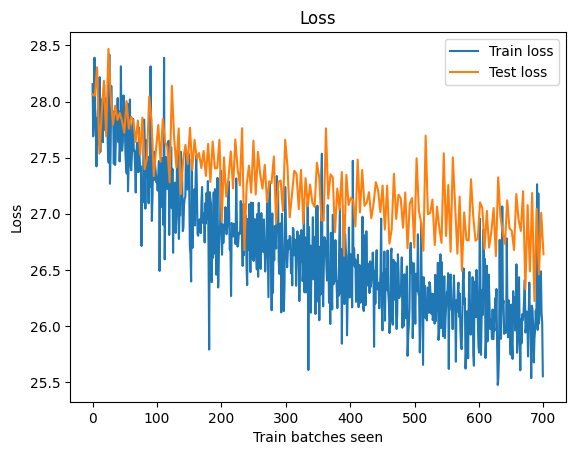

In [21]:
plt.plot(range(len(train_losses)), train_losses, label='Train loss')
ratio = int(len(train_losses) / len(test_losses))
plt.plot(np.linspace(0, len(train_losses), len(test_losses)), test_losses, label='Test loss')
plt.xlabel('Train batches seen')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [22]:
augmented_data = []
model.eval()
for i in trange(data.shape[0]):
  augmented = data[i][0 : 20]
  while augmented.shape[0] < 120:
    past_values = augmented[-20:].reshape((1, 20, 14))
    past_time_features = torch.Tensor(range(augmented.shape[0] - 20, augmented.shape[0])).reshape(1, 20, 1)
    future_time_features = torch.Tensor(range(augmented.shape[0], augmented.shape[0] + 4)).reshape(1, 4, 1)
    past_observed_mask = torch.ones(past_values.shape)
    if i < 83:
      static_categorical_features = torch.Tensor([1]).reshape((1, 1)).int()
    else:
      static_categorical_features = torch.Tensor([0]).reshape((1, 1)).int()
    gen = model.generate(
        past_values=past_values,
        past_time_features=past_time_features,
        future_time_features=future_time_features,
        past_observed_mask=past_observed_mask,
        static_categorical_features=static_categorical_features
    )["sequences"].reshape((4, 14))
    augmented = torch.cat((augmented, gen), dim=0)
  augmented_data.append(augmented)

100%|██████████| 168/168 [00:43<00:00,  3.86it/s]


In [23]:
augmented_data[0].shape

torch.Size([120, 14])

In [24]:
augmented_data = torch.stack(augmented_data)

In [25]:
augmented_data = augmented_data.reshape((168, 14, 120))

In [26]:
augmented_dataset = TensorDataset(augmented_data, labels)
aug_train_dataset, aug_test_dataset = train_test_split(augmented_dataset, test_size=0.3, random_state=44)
aug_train_dataset, aug_val_dataset = train_test_split(aug_train_dataset, test_size=0.3, random_state=44)

batch_size = 32
aug_train_loader = DataLoader(aug_train_dataset, batch_size=batch_size, shuffle=True)
aug_test_loader = DataLoader(aug_test_dataset, batch_size=batch_size, shuffle=True)
aug_val_loader = DataLoader(aug_val_dataset, batch_size=batch_size, shuffle=True)

In [27]:
input_channels = close.shape[0]
model = TimeSeriesCNN(input_channels, 128)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)

In [28]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
aug_accuracy_on_real = []
train_roc_auc = []
test_roc_auc = []
aug_roc_auc_on_real = []
val_losses = []

def aug_train(model):
    num_epochs = 30
    print_every = 5
    patience = 4
    epochs_increasing = 0
    last_loss = 100000
    for epoch in range(num_epochs):
        running_loss = 0.0
        y_train_true = []
        y_train_pred_proba = []

        for inputs, labels in aug_train_loader:
            model.train()
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            y_train_true.extend(labels.cpu().tolist())
            y_train_pred_proba.extend(output.cpu().tolist())
            running_loss += loss.item()

        running_loss /= len(aug_train_loader)
        y_train_true = torch.Tensor(y_train_true)
        y_train_pred_proba = torch.Tensor(y_train_pred_proba)
        train_losses.append(running_loss)
        train_pred = (torch.Tensor(y_train_pred_proba) > 0.5).float()
        accuracy = (train_pred == y_train_true).sum().item() / y_train_true.shape[0]
        train_accuracy.append(accuracy)
        roc_auc = roc_auc_score(y_train_true, y_train_pred_proba)
        train_roc_auc.append(roc_auc)

        test_loss = 0.0
        y_test_true = []
        y_test_pred_proba = []
        for inputs, labels in aug_test_loader:
            model.eval()
            output = model(inputs)
            loss = criterion(output, labels)
            test_loss += loss.item()
            y_test_true.extend(labels.cpu().tolist())
            y_test_pred_proba.extend(output.cpu().tolist())

        test_loss /= len(aug_test_loader)
        y_test_true = torch.Tensor(y_test_true)
        y_test_pred_proba = torch.Tensor(y_test_pred_proba)
        test_losses.append(test_loss)
        test_pred = (torch.Tensor(y_test_pred_proba) > 0.5).float()
        accuracy = (test_pred == y_test_true).sum().item() / y_test_true.shape[0]
        aug_accuracy_on_real.append(accuracy)
        roc_auc = roc_auc_score(y_test_true, y_test_pred_proba)
        aug_roc_auc_on_real.append(roc_auc)

        y_test_true = []
        y_test_pred_proba = []
        for inputs, labels in test_loader:
            output = model(inputs)
            y_test_true.extend(labels.cpu().tolist())
            y_test_pred_proba.extend(output.cpu().tolist())
        y_test_true = torch.Tensor(y_test_true)
        y_test_pred_proba = torch.Tensor(y_test_pred_proba)
        test_pred = (torch.Tensor(y_test_pred_proba) > 0.5).float()
        accuracy = (test_pred == y_test_true).sum().item() / y_test_true.shape[0]
        test_accuracy.append(accuracy)
        roc_auc = roc_auc_score(y_test_true, y_test_pred_proba)
        test_roc_auc.append(roc_auc)

        val_loss = 0.0
        for inputs, labels in aug_val_loader:
            model.eval()
            output = model(inputs)
            loss = criterion(output, labels)
            val_loss += loss.item()

        val_loss /= len(aug_val_loader)
        val_losses.append(val_loss)
        if val_loss > last_loss:
            epochs_increasing += 1
            if epochs_increasing >= patience:
                print('Early stopping!\n')
                return
        else:
            epochs_increasing = 0

        last_loss = val_loss
        if epoch % print_every == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {running_loss:.4f}, Test loss: {test_loss:.4f}")

In [29]:
aug_train(model)

Epoch 1/30, Train loss: 42.2385, Test loss: 36.1480
Epoch 6/30, Train loss: 41.2963, Test loss: 36.0140
Epoch 11/30, Train loss: 39.8751, Test loss: 35.5208
Epoch 16/30, Train loss: 41.0017, Test loss: 35.9282
Epoch 21/30, Train loss: 38.5333, Test loss: 36.3088
Epoch 26/30, Train loss: 38.3563, Test loss: 35.6016


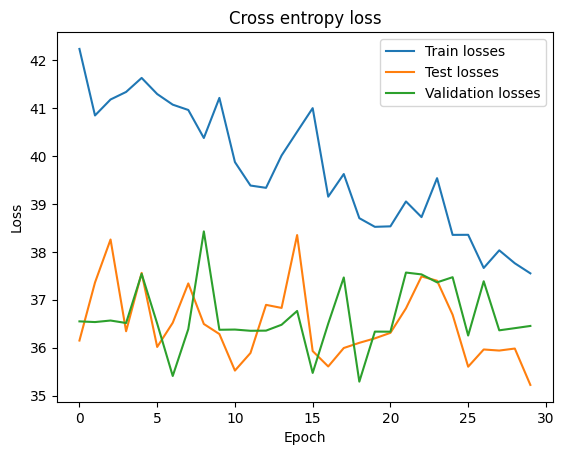

In [30]:
plt.plot(train_losses, label='Train losses')
plt.plot(test_losses, label='Test losses')
plt.plot(val_losses, label='Validation losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss')
plt.legend()
plt.show()

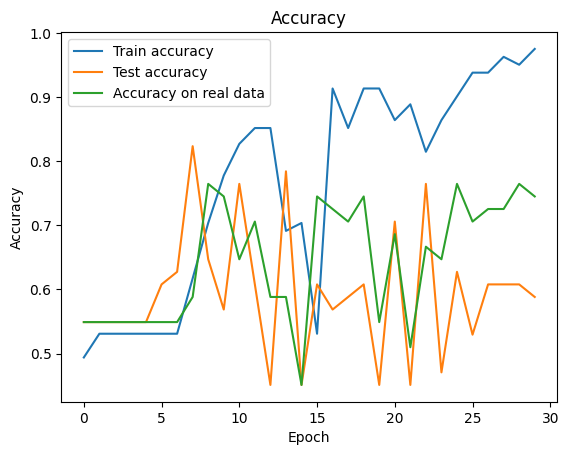

In [31]:
plt.plot(train_accuracy, label='Train accuracy')
plt.plot(test_accuracy, label='Test accuracy')
plt.plot(aug_accuracy_on_real, label='Accuracy on real data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

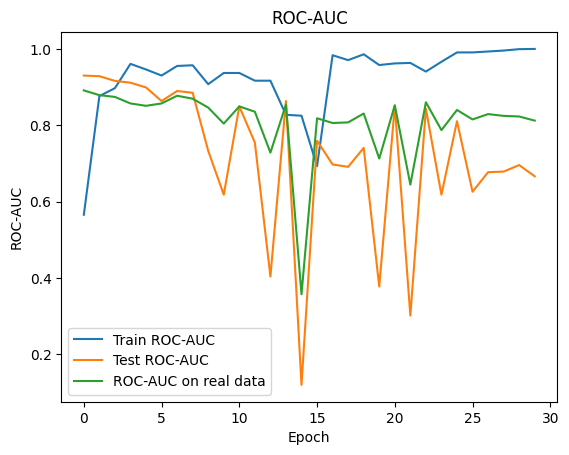

In [32]:
plt.plot(train_roc_auc, label='Train ROC-AUC')
plt.plot(test_roc_auc, label='Test ROC-AUC')
plt.plot(aug_roc_auc_on_real, label='ROC-AUC on real data')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.legend()
plt.show()

In [33]:
combined_dataset = ConcatDataset([train_dataloader.dataset, aug_train_loader.dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

In [34]:
model = TimeSeriesCNN(input_channels, 128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)

In [35]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
aug_accuracy_on_real = []
train_roc_auc = []
test_roc_auc = []
aug_roc_auc_on_real = []
val_losses = []

aug_train(model)

Epoch 1/30, Train loss: 42.0033, Test loss: 36.8648
Epoch 6/30, Train loss: 40.8618, Test loss: 36.3599
Epoch 11/30, Train loss: 40.1947, Test loss: 36.5892
Epoch 16/30, Train loss: 38.5183, Test loss: 36.5821
Epoch 21/30, Train loss: 38.7498, Test loss: 36.2429
Epoch 26/30, Train loss: 38.3507, Test loss: 36.8083


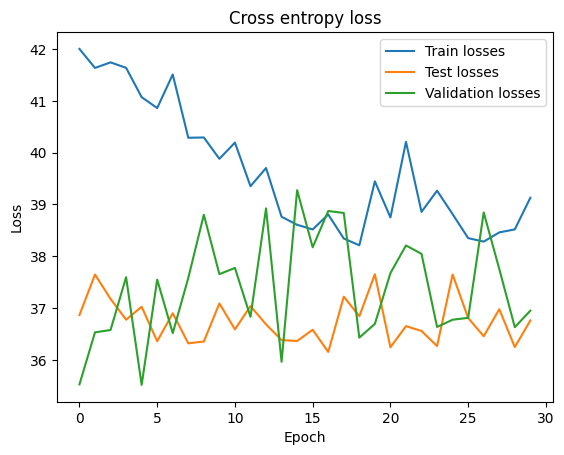

In [36]:
plt.plot(train_losses, label='Train losses')
plt.plot(test_losses, label='Test losses')
plt.plot(val_losses, label='Validation losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss')
plt.legend()
plt.show()

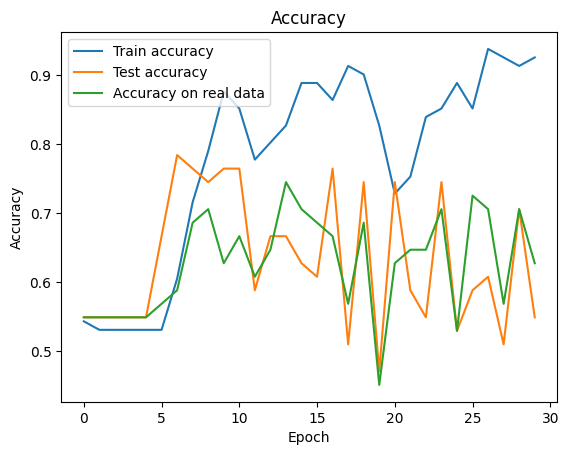

In [37]:
plt.plot(train_accuracy, label='Train accuracy')
plt.plot(test_accuracy, label='Test accuracy')
plt.plot(aug_accuracy_on_real, label='Accuracy on real data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

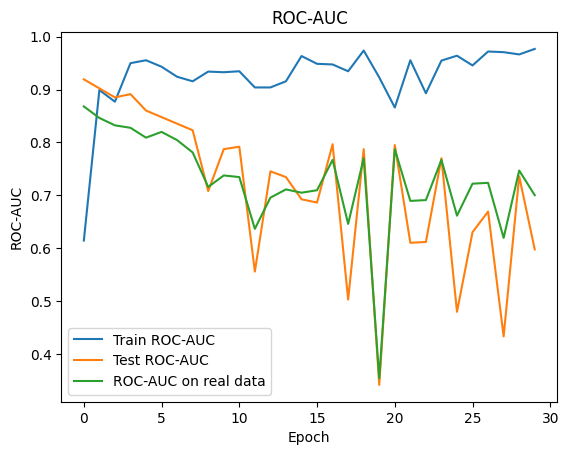

In [38]:
plt.plot(train_roc_auc, label='Train ROC-AUC')
plt.plot(test_roc_auc, label='Test ROC-AUC')
plt.plot(aug_roc_auc_on_real, label='ROC-AUC on real data')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.legend()
plt.show()